In [1]:
import argparse   
import pandas as pd
import os
from Bio import AlignIO 
from Bio import SeqIO
import numpy as np


from operator import itemgetter

def get_items(d,keylist):
    return itemgetter(*keylist)(d)



parser = argparse.ArgumentParser(description='remapping of msa coordinates given a refeference sequence (also containded in the msa)')
if(False):
    #parser.add_argument('-m','--msapath',required=True,help='msa file in fasta format')
    #parser.add_argument('-r','--refseq',required=True,help='reference sequence file in fasta format')

    args = parser.parse_args()
    #msapath = args.msapath
    #refseq = args.refseq
else:
    mapfile = '/data/EBV/msas/splited/whole_mapping.csv'
    whole_recom_rate = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/results_trimmed_177k/RR.tsv'
    gene_coords_file = '/data/EBV/by_gene/gene_result.txt'
    outfile = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/results_trimmed_177k/by_gen_recomb.tsv'

In [2]:
mapp = pd.read_csv(mapfile,sep = '|')
rrate = pd.read_csv(whole_recom_rate,sep = '|')
rrate.set_index(['trimmed_position'],inplace = True)
mapp_dict = mapp[['refCoord','trimmedCoord']]


#dif = rrate.index[1::] - rrate.index[:-1] 
#dif = pd.Series(dif)
#dif.describe()
#dif.shape
#rrate.shape

In [3]:
mapp_dict =  {}
refcoords = mapp.loc[:,'refCoord']
trimcoords = mapp.loc[:,'trimmedCoord']
for i in range(mapp.shape[0]):
    mapp_dict.update({refcoords[i]:trimcoords[i]})

In [4]:
gene_coords = pd.read_csv(gene_coords_file,sep = '\t')
gene_ref_coords = gene_coords[['GeneID','Symbol','Aliases','start_position_on_the_genomic_accession','end_position_on_the_genomic_accession']]

start_col = 'start_position_on_the_genomic_accession'
end_col = 'end_position_on_the_genomic_accession'

In [5]:
st = gene_ref_coords[start_col]#[0]
end = gene_ref_coords[end_col]

# remove values not in trimmed aligment 
drop_rows = (~st.isin(refcoords))|(~end.isin(refcoords))
print 'dropped rows: %s'%(drop_rows).sum()
print gene_ref_coords[drop_rows] 
ref_table = gene_ref_coords[~drop_rows]

ref_table['trimmed_st'] = get_items(mapp_dict,ref_table.start_position_on_the_genomic_accession)
ref_table['trimmed_end'] = get_items(mapp_dict,ref_table.end_position_on_the_genomic_accession)


dropped rows: 1
      GeneID    Symbol Aliases  start_position_on_the_genomic_accession  \
145  8655057  NEWENTRY     NaN                                      NaN   

     end_position_on_the_genomic_accession  
145                                    NaN  


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [6]:
rrate.head()

,Mean Rho/bp.,-95% CI,+95% CI
trimmed_position,,,
1.0,0.166211,0.00117,0.345456
5.0,0.020390,0.00046,0.004540
6.0,0.721680,0.01237,0.370670
17.0,0.020935,0.00192,0.098550
18.0,0.179360,0.00029,3.004330


In [7]:
ref_table.head()

,GeneID,Symbol,Aliases,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,trimmed_st,trimmed_end
0,3783676,A73,HHV4_A73,155549.0,160531.0,160306,165330
1,3783677,BALF1,NaN,164388.0,165255.0,169229,170096
2,3783678,BALF2,HHV4_BALF2,160550.0,164356.0,165349,169197
3,17494228,BALF2,NaN,164979.0,164984.0,169820,169825
4,3783679,BALF3,NaN,158851.0,161220.0,163646,166019


In [8]:
import scipy.integrate as integrate

def mean_value_by_integration(serie):
    mean_value = integrate.trapz(serie.values, serie.index.astype(np.int64))/(serie.index.max()-serie.index.min())
    return(mean_value)


#r1,r2 son valores del indice
def compute_local_obs(rrate,r1,r2):
#    return(rrate[r1:r2])
    return(rrate[r1:r2].apply(np.mean))

res = ref_table.apply(lambda x: pd.concat([x[0:3],
                                          compute_local_obs(rrate,r1 = x.trimmed_st,r2 = x.trimmed_end)]),axis =1)
                     
res.sort_values(by=['Mean Rho/bp.'],inplace=True,ascending = False)




In [10]:
rho_mean, rho_low, rho_up = rrate.apply(mean_value_by_integration)
rrate.apply(mean_value_by_integration)

Mean Rho/bp.    0.005089
-95% CI         0.000629
+95% CI         0.024420
dtype: float64

In [31]:
res2 = ref_table.apply(lambda x: pd.concat([x[0:3],rrate[x.trimmed_st:x.trimmed_end].apply(mean_value_by_integration)]),axis =1)
res2['length'] = ref_table.trimmed_end-ref_table.trimmed_st
res2.sort_values(by=['Mean Rho/bp.'],inplace=True,ascending = False)

res2.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


,GeneID,Symbol,Aliases,Mean Rho/bp.,-95% CI,+95% CI,length
133,3783749,LF3,NaN,0.078497,0.000601,0.445770,2782
32,3783694,BDLF3,HHV4_BDLF3,0.053357,0.001222,0.318924,750
58,3783706,BHRF1,NaN,0.023029,0.000618,0.135209,575
147,3783757,RPMS1,HHV4_RPMS1,0.012666,0.000983,0.083012,22386
137,17494231,LMP2A,NaN,0.012398,0.002016,0.041235,447


In [12]:
(res2.length>20000).sum()

3

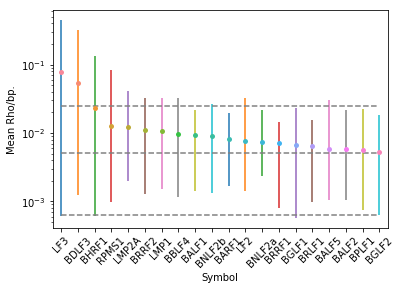

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
ax = plt.subplot(111)

df =res2.head(20)
sns.stripplot(x="Symbol", y="Mean Rho/bp.", data=df,ax = ax);


for x,xlabel in zip(ax.get_xticks(), ax.get_xticklabels()):
    f = df['Symbol'] == xlabel.get_text() 
    y_low = df['Mean Rho/bp.'][f].values - df['-95% CI'][f].values
    y_up = df['+95% CI'][f].values - df['Mean Rho/bp.'][f].values
    ax.errorbar(np.ones_like(df['Mean Rho/bp.'][f].values)*x,df['Mean Rho/bp.'][f].values, yerr=[y_low,y_up], ls='none')
ax.set_yscale('log')

x =ax.get_xticks() 
y,y_low,y_up = rrate.apply(mean_value_by_integration)
ax.plot(x, [y]*len(x), '--',color = 'gray')
ax.plot(x, [y_low]*len(x), '--',color = 'gray')
ax.plot(x, [y_up]*len(x), '--',color = 'gray')

for item in ax.get_xticklabels():
    item.set_rotation(45)


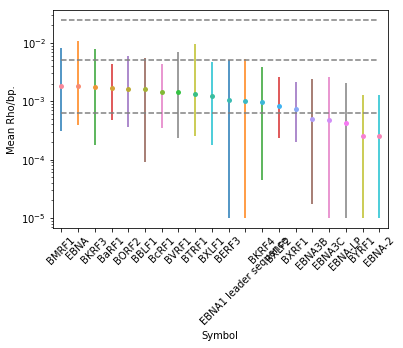

In [15]:
plt.figure()
ax = plt.subplot(111)

df =res2[~res2['Mean Rho/bp.'].isnull()].tail(20)
sns.stripplot(x="Symbol", y="Mean Rho/bp.", data=df,ax = ax);


for x,xlabel in zip(ax.get_xticks(), ax.get_xticklabels()):
    f = df['Symbol'] == xlabel.get_text() 
    y_low = df['Mean Rho/bp.'][f].values - df['-95% CI'][f].values
    y_up = df['+95% CI'][f].values - df['Mean Rho/bp.'][f].values
    ax.errorbar(np.ones_like(df['Mean Rho/bp.'][f].values)*x,df['Mean Rho/bp.'][f].values, yerr=[y_low,y_up], ls='none')
ax.set_yscale('log')

x =ax.get_xticks() 
y,y_low,y_up = rrate.apply(mean_value_by_integration)
ax.plot(x, [y]*len(x), '--',color = 'gray')
ax.plot(x, [y_low]*len(x), '--',color = 'gray')
ax.plot(x, [y_up]*len(x), '--',color = 'gray')

for item in ax.get_xticklabels():
    item.set_rotation(45)


In [16]:
print 'sin señal %s genes'%res2['Mean Rho/bp.'].isnull().sum()
print 'CON señal %s genes'% (~res2['Mean Rho/bp.'].isnull()).sum()

sin señal 60 genes
CON señal 92 genes


In [17]:
res2.to_csv(outfile,sep ='|',index = False)

In [18]:
from Bio import AlignIO 
from Bio import SeqIO

In [19]:
seq_record = SeqIO.read('/data/EBV/byACCIDs/genBankRecord_NC_007605.gb','genbank')

In [20]:
types = []
cds = []
region =[]
for feature in seq_record.features:
    types.append(feature.type)
    if 'gene' in feature.qualifiers.keys():
        gene = feature.qualifiers['gene']
    else:
        gene = 'None'
    
    partes = []
    for p in feature.location.parts:
        partes.append(pd.Series([p.start.position,p.end.position]))
    positions = pd.concat(partes,1).transpose()    
    positions.columns = ['start','end']
    positions['type'] = feature.type
    positions['gene'] = np.repeat(gene,positions.shape[0])

    
    region.append(positions)
regions = pd.concat(region)

regions = regions[regions.type!='source']

# compute length of each region
regions['length'] = regions.end - regions.start
regions['length'] = pd.to_numeric(regions.length)

regions = regions[regions.length < 40000] # con esto tiramos la anomalia del primer gen. 

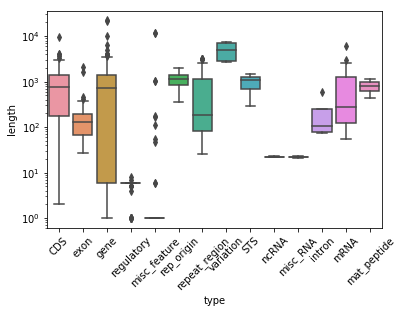

In [21]:
ax = sns.boxplot(x ='type',y = 'length', data = regions)
ax.set_yscale('log')

for item in ax.get_xticklabels():
    item.set_rotation(45)

In [22]:
regions['rango'] = regions.apply(lambda x: (x.start,x.end),1)
regions.set_index('rango',inplace = True)
regions.head()

,start,end,type,gene,length
rango,,,,,
"(166102, 166458)",166102,166458,CDS,LMP2,356
"(57, 272)",57,272,CDS,LMP2,215
"(359, 458)",359,458,CDS,LMP2,99
"(539, 788)",539,788,CDS,LMP2,249
"(870, 951)",870,951,CDS,LMP2,81


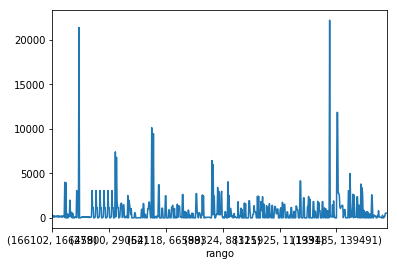

In [23]:
regions.length.plot()

In [24]:
res3 = regions.apply(lambda x: pd.concat([x[2:5],rrate[x.start:x.end].apply(mean_value_by_integration)]),axis =1)
res3.sort_values(by=['Mean Rho/bp.'],inplace=True,ascending = False)

res3.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


,type,gene,length,Mean Rho/bp.,-95% CI,+95% CI
rango,,,,,,
"(9020, 9133)",misc_feature,LMP2,113,0.019088,0.004361,0.317467
"(44659, 46237)",CDS,BFLF1,1578,0.017827,0.000633,0.097572
"(139722, 151555)",misc_feature,RPMS1,11833,0.017810,0.000805,0.133781
"(139723, 151554)",misc_feature,RPMS1,11831,0.017810,0.000805,0.133781
"(104492, 105098)",CDS,BBLF2-BBLF3,606,0.016779,0.001538,0.066765


In [34]:
res3.groupby(['type','gene'])['length','Mean Rho/bp.','-95% CI','+95% CI'].mean()/rho_mean

length  \
type          gene                                                        
CDS           A73                                          18715.901285   
              BALF1                                       130274.462487   
              BALF2                                       665519.765374   
              BALF3                                       465686.992600   
              BALF4                                       505771.442596   
              BALF5                                       598908.841116   
              BARF0                                       278233.241148   
              BARF1                                       130863.939693   
              BBLF1                                        44800.267643   
              BBLF2-BBLF3                                 213390.748508   
              BBLF4                                       477476.536717   
              BBRF2                                       164464.140425   
              BBRF3                                       239327.745564   
              BCRF1                                       100800.602196   
              BCRF2                                       226359.247036   
              BDLF1                                       178022.116159   
              BDLF2                                       248169.903652   
              BDLF3                                       138527.143368   
              BDLF4                                       133221.848516   
              BFLF1                                       310065.010263   
              BFLF2                                       188043.228658   
              BFRF1                                       198653.818362   
              BFRF1A                                       80168.899992   
              BFRF2                                       348970.505847   
              BFRF3                                       104337.465431   
              BGLF1                                       299454.420558   
              BGLF2                                       198653.818362   
              BGLF3                                       196295.909539   
              BGLF3.5                                      90779.489697   
              BGLF4                                       253475.198504   
...                                                                 ...   
regulatory    BZLF2                                         1178.954412   
              BaRF1                                         1178.954412   
              BcLF1                                         1178.954412   
              BcRF1                                         1178.954412   
              BdRF1                                         1178.954412   
              EBNA-1                                        1178.954412   
              EBNA-2                                        1178.954412   
              EBNA-3C                                       1178.954412   
              EBNA-LP                                        196.492402   
              EBNA3A                                        1178.954412   
              LMP1                                          1178.954412   
              LMP2                                          1178.954412   
              LMP2A                                         1178.954412   
              None                                          1178.954412   
              RPMS1                                         1178.954412   
              RPMS1 and A73 RNAs                            1178.954412   
              SM                                            1178.954412   
              lytic LMP1                                    1178.954412   
              possible start for 2kb RNAs crossing BILF2    1178.954412   
rep_origin    LMP2                                        219220.023099   
              RPMS1                                       243257.593603   
repeat_region B

count     3048.000000
mean        57.812992
std        291.832261
min          1.000000
25%          7.000000
50%         22.000000
75%         61.000000
max      13262.000000
Name: trimmed_position, dtype: float64

In [403]:
dif.quantile(0.99)

364.650000000001

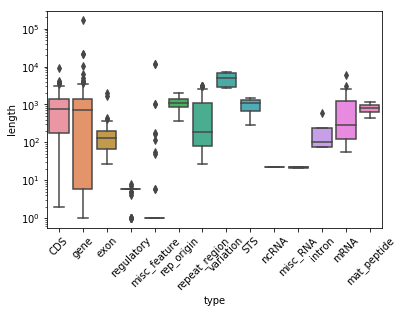

In [252]:
regions.head()

,type,start,end,length
3,CDS,57,166458,166401
4,gene,57,166458,166401
5,exon,57,272,215
6,CDS,58,1680,1622
7,exon,359,458,99


In [224]:
pd.value_counts(types)

gene             152
regulatory       125
CDS               95
misc_feature      51
exon              39
repeat_region     39
mRNA               7
intron             4
variation          4
rep_origin         4
source             3
misc_RNA           3
ncRNA              3
STS                3
mat_peptide        2
dtype: int64

In [256]:
regions[regions.type =='exon']

,type,start,end,length
5,exon,57,272,215
7,exon,359,458,99
8,exon,539,788,249
9,exon,870,951,81
10,exon,1025,1196,171
11,exon,1279,1495,216
12,exon,1573,1682,109
18,exon,5407,5856,449
32,exon,11335,11480,145
33,exon,11625,11657,32
